# 📌 ADIA Lab Structural Break Challenge  

**Assalam o Alaikum👋**  
In this notebook, we are going to explore the concept of **structural breaks (regime shifts)** – basically jab data ka trend, mean, or variance suddenly change ho jaye 📊.  

Structural break detection is an important problem because real-world data kabhi bhi smooth aur stable nahi hota. Kabhi kabhi beech me major shifts aate hain jo forecasting aur analysis dono ko effect kar dete hain.  

---

## 🔎 Challenge Overview  

Welcome to the **ADIA Lab Structural Break Challenge!**  
In this competition, you will analyze **univariate time series data** to determine whether a **structural break** has occurred at a specified boundary point.  

### 📖 What is a Structural Break?  

A **structural break** occurs when the process governing the data generation changes at a certain point in time.  
These changes can be subtle or dramatic, and detecting them accurately is crucial across domains:  

- 🌦 **Climatology** → shifts in long-term weather patterns  
- 🏭 **Industrial Monitoring** → detecting sudden machine behavior changes  
- 💹 **Finance** → market crashes or regime shifts  
- 🏥 **Healthcare** → sudden change in patient health indicators  

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)  

---

## 📝 Our Task  

For each time series in the **test set**, we need to predict a **score between `0` and `1`:**  

- `0` → No structural break at the specified boundary point  
- `1` → A structural break **did occur**  

---

## 📊 Evaluation Metric  

The challenge uses **ROC AUC (Area Under the Receiver Operating Characteristic Curve)** as the evaluation metric:  

- **ROC AUC ≈ 0.5** → No better than random guessing  
- **ROC AUC → 1.0** → Perfect detection performance  

More about ROC AUC: [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  

---

## 📂 Notebook Flow 🚀  

1. **Exploratory Data Analysis (EDA)** – visualize aur samajhenge dataset.  
2. **Methods** – different techniques (statistical + ML-based) try karenge for break detection.  
3. **Evaluation** – compare karenge results aur dekhenge kaun sa method best perform karta hai.  

---

⚡ **Goal**: A clean, reproducible, and easy-to-follow Kaggle-style notebook – jahan beginner bhi seekh le aur advanced banda bhi enjoy kare.  

**Chalo shuru karte hain 🚀**  


In [2]:
# import Important Libraries

!pip install antropy --quiet
!pip install PyWavelets --quiet


In [44]:
import os
import typing

# Import your dependencies
import joblib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sklearn.metrics
from scipy.stats import wasserstein_distance  # 1D Earth Mover's Distance
from scipy.stats import skew, kurtosis, ks_2samp
from scipy.stats import wasserstein_distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from scipy.stats import skew, kurtosis, ks_2samp, mannwhitneyu, wasserstein_distance
from scipy.signal import welch, hilbert
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # suppress welch nperseg warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random



from scipy.signal import welch
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Crunch CLI SETUP

In [6]:
### CRunch CLI Setup

%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break NQ2RWgO05SaZaHUUaPYINw45

import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

# Load the data simply
X_train, y_train, X_test = crunch.load_data()

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.4.0
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                                                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_no

### BASIC EDA

In [19]:
# --- Dataset Overview ---
print("📂 Total training subsequences:", len(X_train))
print(X_train.shape)
print("📂 Total test subsequences:", len(X_test))
print("📂 y_train length:", len(y_train))

# --- Target Labels ---
print("\n📊 y_train distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# --- Check Nulls in y_train ---
print("\n📉 Missing values in y_train:", y_train.isnull().sum())

# --- Test set EDA (corrected) ---
print("\n📂 Test set overview:")
print("Number of test series:", len(X_test))
print("Shape of first 5 test series:", [np.array(df).shape for df in X_test[:5]])

# --- Nulls in X_train (safe) ---
train_nulls = 0
for x in X_train[:1000]:  # sample 1000 series
    try:
        arr = np.array(x, dtype=float)
        train_nulls += np.isnan(arr).sum()
    except:
        # non-numeric series
        train_nulls += 0

print(f"\n📉 Null values in first 1000 training series: {train_nulls}")

# --- Nulls in X_test (safe) ---
test_nulls = 0
for x in X_test:
    try:
        arr = np.array(x, dtype=float)
        test_nulls += np.isnan(arr).sum()
    except:
        test_nulls += 0

print(f"📉 Null values in test series: {test_nulls}")

# --- Example lengths of sequences ---
train_lengths = [len(x) for x in X_train[:1000]]  # sample
print(f"\n📏 Training series length stats (sample 1000):")
print("Number of datasets:", len(X_test))
print(pd.Series(train_lengths).describe())

📂 Total training subsequences: 23715734
(23715734, 2)
📂 Total test subsequences: 101
📂 y_train length: 10001

📊 y_train distribution:
structural_breakpoint
False    0.709129
True     0.290871
Name: proportion, dtype: float64
structural_breakpoint
False    7092
True     2909
Name: count, dtype: int64

📉 Missing values in y_train: 0

📂 Test set overview:
Number of test series: 101
Shape of first 5 test series: [(2779, 2), (1966, 2), (1775, 2), (3296, 2), (1995, 2)]

📉 Null values in first 1000 training series: 0
📉 Null values in test series: 0

📏 Training series length stats (sample 1000):
Number of datasets: 101
count    2.000000
mean     5.500000
std      0.707107
min      5.000000
25%      5.250000
50%      5.500000
75%      5.750000
max      6.000000
dtype: float64


## 📝 Basic EDA Notes (Updated)

- **Total Training Subsequences:** 23,715,734  
- **Total Test Subsequences:** 101  
- **y_train Length:** 10,001  

### 📊 y_train Distribution
- **Proportion:**  
  - False: 70.9%  
  - True: 29.1%  
- **Counts:**  
  - False: 7,092  
  - True: 2,909  
- Label imbalance exists → metric ROC AUC is robust to this.

### 📉 Missing Values
- **y_train:** 0  
- **X_train (first 1000 series):** 0  
- **X_test:** 0  
- No missing data → preprocessing easier.

### 📂 Test Set Overview
- Number of test series: 101  
- Shape of first 5 test series: `(2779,2), (1966,2), (1775,2), (3296,2), (1995,2)`  
- Each test series has variable length but 2 columns (probably period & value).

### 📏 Training Series Lengths (Sample 1000)
- Min: 5, Max: 6, Mean: 5.5  
- Mostly very short sequences → statistical/ML models will work on small windows.

**Notes:**  
- Dataset has **very large number of training subsequences**  
- No missing values → safe to use directly  
- Label imbalance is moderate → consider for evaluation metric  
- Next steps: visualize sample series, inspect True vs False structural breaks.


### Visualization of series

### visualize a single time series

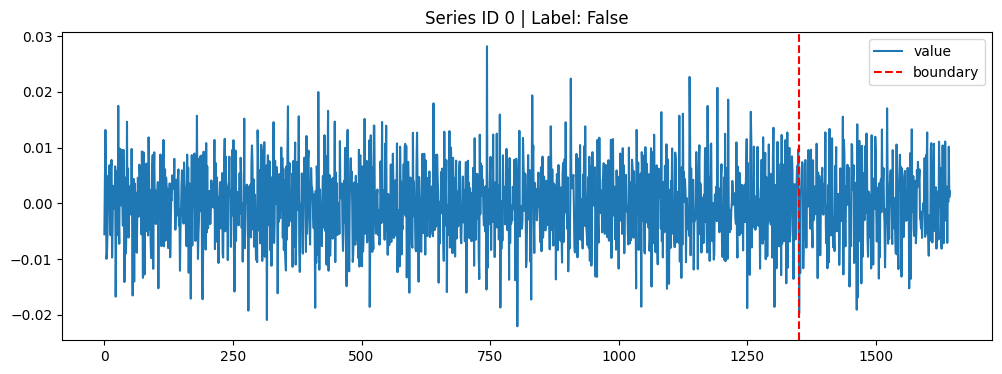

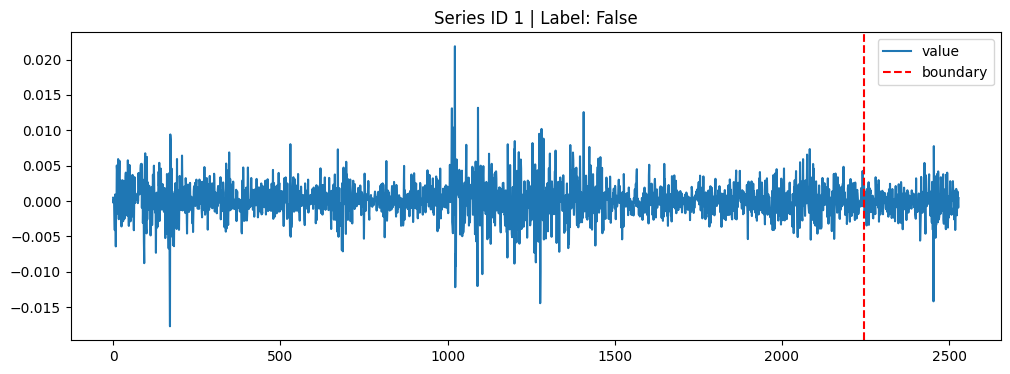

In [9]:
# visualize a single time series
def plot_series(series_id):
    df = X_train.loc[series_id]
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["value"], label="value")
    plt.axvline(x=df[df["period"]==0].index.max(), color="red", linestyle="--", label="boundary")
    plt.title(f"Series ID {series_id} | Label: {y_train.loc[series_id]}")
    plt.legend()
    plt.show()

plot_series(0)
plot_series(1)


### Length of series

In [10]:
#Length of series
series_lengths = X_train.groupby("id").size()
display(series_lengths.describe())

count    10001.000000
mean      2371.336266
std        482.645935
min       1258.000000
25%       1991.000000
50%       2369.000000
75%       2743.000000
max       3478.000000
dtype: float64

### Mean aur Std deviation comparison before and after the structural break:


Series 2 | Label: True
Before mean: 0.0003892051236000776  | std: 0.017221361838717496
After  mean: 0.0017896691818350308  | std: 0.022899626080259385


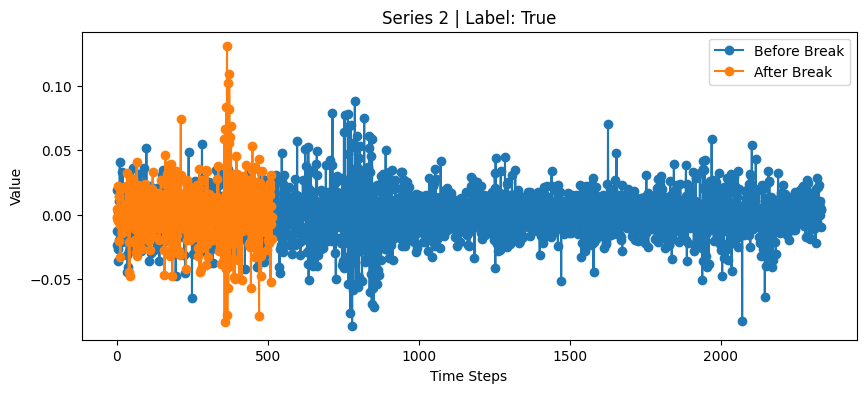

Series 0 | Label: False
Before mean: 1.45894149863421e-05  | std: 0.006987461835288747
After  mean: 6.371869815417522e-06  | std: 0.006876778367900677


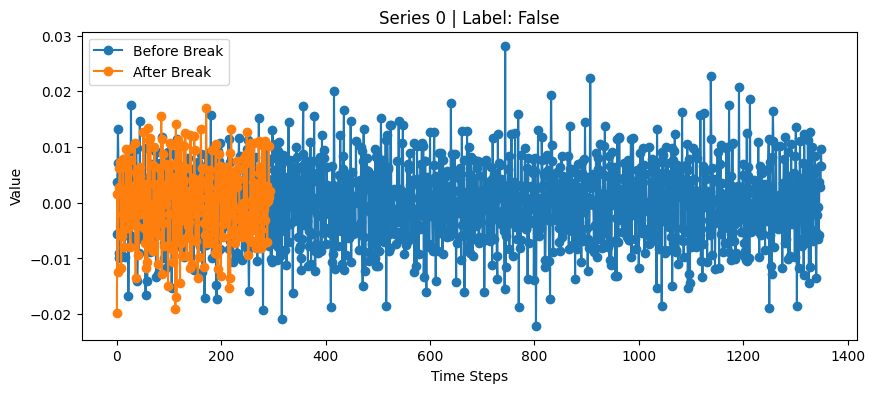

In [17]:
# Get indices
true_idx = y_train[y_train==True].index[0]
false_idx = y_train[y_train==False].index[0]

def compare_stats_plot(series_id):
    df = X_train.loc[series_id]  # assuming period & value columns
    before = df[df["period"]==0]["value"]
    after  = df[df["period"]==1]["value"]
    
    print(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    print("Before mean:", before.mean(), " | std:", before.std())
    print("After  mean:", after.mean(), " | std:", after.std())
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(before.values, marker='o', label='Before Break')
    plt.plot(after.values, marker='o', label='After Break')
    plt.title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Compare True series
compare_stats_plot(true_idx)

# Compare False series
compare_stats_plot(false_idx)


## 🔍 Structural Break Interpretation

**Series 0 | Label: False**  
- Mean before: 1.46e-5 | after: 6.37e-6  
- Std before: 0.00699 | after: 0.00688  
- Observation: Mean and std are almost the same → **No significant change**  
- Conclusion: **No structural break**  

**Series 2 | Label: True**  
- Mean before: 0.000389 | after: 0.00179  
- Std before: 0.0172 | after: 0.0229  
- Observation: Both mean and std increased → **Noticeable change in distribution**  
- Conclusion: **Structural break exists**  

**Summary:**  
- **False series:** stable values, no break  
- **True series:** sudden change in mean/variance → structural break


### Compariseon true and fase labels

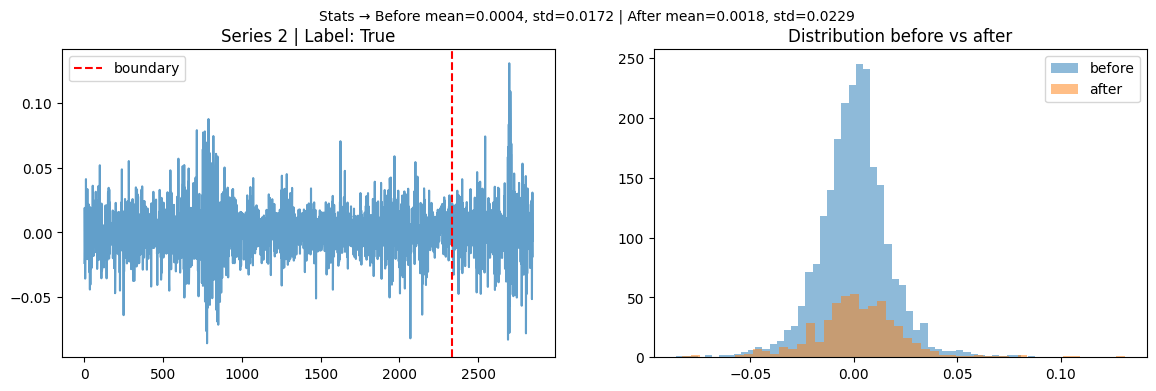

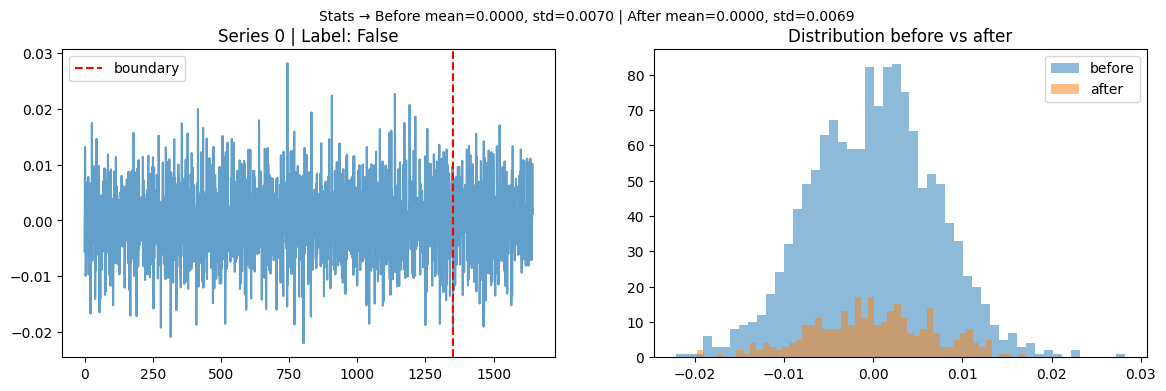

In [14]:
# Compariseon true and fase labels
def compare_true_false(X_train, y_train, true_id=None, false_id=None):
    # agar ID pass na ki ho to first True/False pick karo
    if true_id is None:
        true_id = y_train[y_train == True].index[0]
    if false_id is None:
        false_id = y_train[y_train == False].index[0]
    
    for series_id in [true_id, false_id]:
        df = X_train.loc[series_id]
        before = df[df["period"]==0]["value"]
        after  = df[df["period"]==1]["value"]
        
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        
        # time series plot
        axes[0].plot(df.index, df["value"], alpha=0.7)
        boundary = df[df["period"]==0].index.max()
        axes[0].axvline(boundary, color="red", linestyle="--", label="boundary")
        axes[0].set_title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
        axes[0].legend()
        
        # histogram compare
        axes[1].hist(before, bins=50, alpha=0.5, label="before")
        axes[1].hist(after, bins=50, alpha=0.5, label="after")
        axes[1].set_title("Distribution before vs after")
        axes[1].legend()
        
        plt.suptitle(f"Stats → Before mean={before.mean():.4f}, std={before.std():.4f} | After mean={after.mean():.4f}, std={after.std():.4f}", fontsize=10)
        plt.show()

# run example
compare_true_false(X_train, y_train)



In [18]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

## 🔹 Advanced Feature Engineering Strategy

Our goal is to transform raw time series data into **informative features** that capture both statistical properties and structural changes between "before" and "after" segments. This enables machine learning models to detect subtle patterns indicative of structural breaks or anomalies.

---

### 1️⃣ Segmentation
- Each time series is divided into two segments based on the `period` column:
  - **Before (period=0)**
  - **After  (period=1)**
- Null values are dropped to ensure robust calculations.
- Short segments (<8 samples) are skipped to maintain reliability.

---

### 2️⃣ Basic Statistical Features
For both segments, compute:
- **Mean & Median** → central tendency
- **Standard Deviation (std)** → spread
- **Interquartile Range (IQR)** → variability

**Differences & Ratios:**
- Mean difference (`mean_diff = after_mean - before_mean`)
- Median difference (`median_diff`)
- Std difference & ratio (`std_diff`, `std_ratio`)
- IQR difference (`iqr_diff`)

These capture shifts in distribution after the structural break.

---

### 3️⃣ Complexity & Entropy Features
- **Permutation Entropy (PE)** → measure randomness/complexity of the signal
- **Multiscale Sample Entropy (MSE)** → complexity over multiple scales
- Compute differences between `after` and `before`:
  - `pe_m3_t1_diff`, `pe_m5_t1_diff`, `mse_diff`

---

### 4️⃣ Distance & Statistical Tests
- **Wasserstein Distance (EMD)** → distributional shift
- **Kolmogorov-Smirnov Statistic (KS)** → statistical difference between distributions
- **Mann-Whitney U Test p-value** → non-parametric comparison

---

### 5️⃣ Autocorrelation & Frequency Features
- **ACF Energy Difference** → captures change in temporal correlation
- **Spectral Features**:
  - Spectral Entropy difference → disorder in frequency domain
  - Spectral Centroid difference → shift in frequency “center of mass”
- **Wavelet Energy Difference** → change in localized energy across scales
- **Hilbert Instantaneous Frequency Difference** → change in dominant instantaneous frequency

---

### 6️⃣ Compression & Complexity
- **Lempel-Ziv Complexity (LZ)** difference → change in signal compressibility

---

### 7️⃣ Robustness
- All features handle missing values and small sequences safely.
- Infinite values replaced with 0.
- Optional libraries like `antropy` and `pywt` used if available, with safe fallbacks.

---

### ✅ Key Insight
- This approach captures **both statistical and structural changes** in time series.
- Combines **distributional, spectral, temporal, and complexity-based features**.
- Creates a rich feature matrix suitable for **machine learning models** like Logistic Regression, Random Forest, or XGBoost.



### 🔥 Advanced Feature Engineering Function

In [29]:
# optional libs - safe to import if installed
try:
    import antropy as ant
except Exception:
    ant = None
try:
    import pywt
except Exception:
    pywt = None

# --- helper funcs (robust + small fixes) ---
def compute_permutation_entropy(x, m=3, tau=1):
    if ant is None or len(x) < (m + 1):
        return np.nan
    try:
        return float(ant.perm_entropy(x, order=m, delay=tau, normalize=True))
    except Exception:
        return np.nan

def compute_multiscale_entropy(x, scales=(2,3,5)):
    if ant is None:
        return np.nan
    vals = []
    for s in scales:
        xs = x[::s]
        if len(xs) > 10:
            try:
                vals.append(float(ant.sample_entropy(xs)))
            except Exception:
                pass
    return float(np.mean(vals)) if vals else np.nan

def spectral_features(x, fs=1.0):
    # safe nperseg
    nperseg = min(256, max(8, len(x)))
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    # spectral entropy fallback
    if ant is not None:
        try:
            se = float(ant.spectral_entropy(x, sf=fs, method='welch', normalize=True))
        except Exception:
            P = Pxx / (Pxx.sum() + 1e-12)
            se = float(-np.sum(P * np.log(P + 1e-12)))
    else:
        P = Pxx / (Pxx.sum() + 1e-12)
        se = float(-np.sum(P * np.log(P + 1e-12)))
    centroid = float(np.sum(f * Pxx) / (np.sum(Pxx) + 1e-12))
    return se, centroid

def wavelet_energy(x, wavelet='db1', level=3):
    if pywt is None:
        return np.nan, np.nan
    try:
        coeffs = pywt.wavedec(x, wavelet, level=level)
        energies = [np.sum(c**2) for c in coeffs if len(c) > 0]
        return float(np.mean(energies)), float(np.std(energies))
    except Exception:
        return np.nan, np.nan

def lz_complexity(x):
    if ant is None:
        return np.nan
    try:
        sig = np.sign(x - np.nanmean(x)).astype(int)
        return float(ant.lziv_complexity(sig))
    except Exception:
        return np.nan

def robust_stats(arr):
    return {
        'mean': float(np.nanmean(arr)),
        'median': float(np.nanmedian(arr)),
        'std': float(np.nanstd(arr)),
        'iqr': float(np.nanpercentile(arr,75) - np.nanpercentile(arr,25))
    }

# --- cleaned main builder ---
def build_advanced_features(X_df, y_series):
    """
    X_df: MultiIndex DataFrame (id, time) with columns ['value','period']
    y_series: pd.Series indexed by id
    Returns: X_features (DataFrame indexed by id), y_features (Series)
    """
    rows = []
    ids = []

    for sid, df in X_df.groupby(level='id', sort=False):
        df = df.dropna(subset=['value'])
        before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
        after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

        # skip too short segments
        if len(before) < 8 or len(after) < 8:
            continue

        # basic stats once
        b = robust_stats(before)
        a = robust_stats(after)

        feats = {
            'b_mean': b['mean'], 'a_mean': a['mean'],
            'b_median': b['median'], 'a_median': a['median'],
            'b_std': b['std'], 'a_std': a['std'],
            'b_iqr': b['iqr'], 'a_iqr': a['iqr'],
        }

        # diffs/ratios
        feats['mean_diff'] = feats['a_mean'] - feats['b_mean']
        feats['median_diff'] = feats['a_median'] - feats['b_median']
        feats['std_diff'] = feats['a_std'] - feats['b_std']
        feats['iqr_diff'] = feats['a_iqr'] - feats['b_iqr']
        feats['std_ratio'] = (feats['a_std'] + 1e-9) / (feats['b_std'] + 1e-9)

        # complexity: compute once per side (no duplicates)
        feats['pe_m3_t1_diff'] = compute_permutation_entropy(after, m=3, tau=1) - compute_permutation_entropy(before, m=3, tau=1)
        feats['pe_m5_t1_diff'] = compute_permutation_entropy(after, m=5, tau=1) - compute_permutation_entropy(before, m=5, tau=1)
        feats['mse_diff'] = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)

        # distances/tests
        try:
            feats['emd'] = float(wasserstein_distance(before, after))
        except:
            feats['emd'] = np.nan
        try:
            feats['ks_stat'] = float(ks_2samp(before, after).statistic)
        except:
            feats['ks_stat'] = np.nan
        try:
            feats['mw_p'] = float(mannwhitneyu(before, after).pvalue)
        except:
            feats['mw_p'] = np.nan

        # acf energy diff
        try:
            acf_b = np.nan_to_num(acf(before, nlags=20, fft=True))
            acf_a = np.nan_to_num(acf(after, nlags=20, fft=True))
            feats['acf_energy_diff'] = float(np.sum(acf_a**2) - np.sum(acf_b**2))
        except:
            feats['acf_energy_diff'] = np.nan

        # spectral & wavelet
        se_b, cent_b = spectral_features(before)
        se_a, cent_a = spectral_features(after)
        feats['spectral_entropy_diff'] = se_a - se_b
        feats['spectral_centroid_diff'] = cent_a - cent_b

        we_b_mean, we_b_std = wavelet_energy(before)
        we_a_mean, we_a_std = wavelet_energy(after)
        feats['wavelet_energy_diff'] = we_a_mean - we_b_mean

        # hilbert instantaneous freq diff
        try:
            inst_b = np.mean(np.diff(np.unwrap(np.angle(hilbert(before)))))
            inst_a = np.mean(np.diff(np.unwrap(np.angle(hilbert(after)))))
            feats['hilbert_freq_diff'] = float(inst_a - inst_b)
        except:
            feats['hilbert_freq_diff'] = np.nan

        # compression
        feats['lz_diff'] = lz_complexity(after) - lz_complexity(before)

        rows.append(feats)
        ids.append(sid)

    X_features = pd.DataFrame(rows, index=ids)
    X_features.index.name = 'id'
    X_features = X_features.replace([np.inf, -np.inf], np.nan).fillna(0)
    y_features = y_series.loc[X_features.index].astype(int)

    return X_features, y_features


def extract_features_series(df):
    """
    df: DataFrame with columns ['value','period'] for a single id
    returns: dict of features (same keys as build_advanced_features)
    """
    df = df.dropna(subset=['value'])
    before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
    after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

    # skip too short segments
    if len(before) < 8 or len(after) < 8:
        return None

    b = robust_stats(before)
    a = robust_stats(after)

    feats = {
        'b_mean': b['mean'], 'a_mean': a['mean'],
        'b_median': b['median'], 'a_median': a['median'],
        'b_std': b['std'], 'a_std': a['std'],
        'b_iqr': b['iqr'], 'a_iqr': a['iqr'],
    }

    feats['mean_diff']   = feats['a_mean'] - feats['b_mean']
    feats['median_diff'] = feats['a_median'] - feats['b_median']
    feats['std_diff']    = feats['a_std'] - feats['b_std']
    feats['iqr_diff']    = feats['a_iqr'] - feats['b_iqr']
    feats['std_ratio']   = (feats['a_std'] + 1e-9) / (feats['b_std'] + 1e-9)

    # complexity
    feats['pe_m3_t1_diff'] = compute_permutation_entropy(after, m=3, tau=1) - compute_permutation_entropy(before, m=3, tau=1)
    feats['pe_m5_t1_diff'] = compute_permutation_entropy(after, m=5, tau=1) - compute_permutation_entropy(before, m=5, tau=1)
    feats['mse_diff']      = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)

    # distances/tests
    try:
        feats['emd'] = float(wasserstein_distance(before, after))
    except:
        feats['emd'] = np.nan
    try:
        feats['ks_stat'] = float(ks_2samp(before, after).statistic)
    except:
        feats['ks_stat'] = np.nan
    try:
        feats['mw_p'] = float(mannwhitneyu(before, after).pvalue)
    except:
        feats['mw_p'] = np.nan

    # acf energy diff
    try:
        acf_b = np.nan_to_num(acf(before, nlags=20, fft=True))
        acf_a = np.nan_to_num(acf(after, nlags=20, fft=True))
        feats['acf_energy_diff'] = float(np.sum(acf_a**2) - np.sum(acf_b**2))
    except:
        feats['acf_energy_diff'] = np.nan

    # spectral & wavelet
    se_b, cent_b = spectral_features(before)
    se_a, cent_a = spectral_features(after)
    feats['spectral_entropy_diff']  = se_a - se_b
    feats['spectral_centroid_diff'] = cent_a - cent_b

    we_b_mean, we_b_std = wavelet_energy(before)
    we_a_mean, we_a_std = wavelet_energy(after)
    feats['wavelet_energy_diff'] = we_a_mean - we_b_mean

    # hilbert instantaneous freq diff
    try:
        inst_b = np.mean(np.diff(np.unwrap(np.angle(hilbert(before)))))
        inst_a = np.mean(np.diff(np.unwrap(np.angle(hilbert(after)))))
        feats['hilbert_freq_diff'] = float(inst_a - inst_b)
    except:
        feats['hilbert_freq_diff'] = np.nan

    # compression
    feats['lz_diff'] = lz_complexity(after) - lz_complexity(before)

    return feats


In [30]:
# --- Apply feature engineering to check the impact ---
X_features, y_features = build_advanced_features(X_train, y_train)
print(X_features.shape)
print(y_features.value_counts())

(10001, 25)
structural_breakpoint
0    7092
1    2909
Name: count, dtype: int64


In [32]:
X_features.sample()

,b_mean,a_mean,b_median,a_median,b_std,a_std,b_iqr,a_iqr,mean_diff,median_diff,...,mse_diff,emd,ks_stat,mw_p,acf_energy_diff,spectral_entropy_diff,spectral_centroid_diff,wavelet_energy_diff,hilbert_freq_diff,lz_diff
id,,,,,,,,,,,,,,,,,,,,,
1252,0.001248,0.00077,0.001011,0.000678,0.015374,0.01347,0.017348,0.014651,-0.000477,-0.000334,...,0.0,0.0015,0.060185,0.351998,0.019081,-0.015618,-0.002118,-0.094576,-0.000608,-113.0


In [33]:
def inspect_random_series(X_train, n=3, seed=42):
    """
    Inspect raw vs preprocessed before/after arrays for random series
    """
    rng = np.random.default_rng(seed)
    series_ids = rng.choice(X_train.index.get_level_values("id").unique(), n, replace=False)

    for sid in series_ids:
        df = X_train.loc[sid][["value", "period"]]

        # Raw arrays
        before_raw = df.loc[df["period"] == 0, "value"].to_numpy()
        after_raw  = df.loc[df["period"] == 1, "value"].to_numpy()

        # Preprocessed arrays (dropna)
        before_clean = df.loc[df["period"] == 0, "value"].dropna().to_numpy()
        after_clean  = df.loc[df["period"] == 1, "value"].dropna().to_numpy()

        print("="*50)
        print(f"Series ID: {sid}")
        print(f"Before raw size: {before_raw.size}, After raw size: {after_raw.size}")
        print(f"Before clean size: {before_clean.size}, After clean size: {after_clean.size}")

        # Show first few values
        print("\nRaw Before (first 8):", before_raw[:8])
        print("Clean Before (first 8):", before_clean[:8])

        print("\nRaw After (first 8):", after_raw[:8])
        print("Clean After (first 8):", after_clean[:8])
        print()


inspect_random_series(X_train, n=3)



Series ID: 6546
Before raw size: 1917, After raw size: 882
Before clean size: 1917, After clean size: 882

Raw Before (first 8): [ 0.01868777 -0.02221984 -0.00035981 -0.00103833  0.00774889  0.00711877
 -0.00150918 -0.00799758]
Clean Before (first 8): [ 0.01868777 -0.02221984 -0.00035981 -0.00103833  0.00774889  0.00711877
 -0.00150918 -0.00799758]

Raw After (first 8): [ 0.00211232  0.01734341 -0.00443108 -0.00145321 -0.00555081  0.01040631
  0.00059745 -0.00151384]
Clean After (first 8): [ 0.00211232  0.01734341 -0.00443108 -0.00145321 -0.00555081  0.01040631
  0.00059745 -0.00151384]

Series ID: 892
Before raw size: 1289, After raw size: 641
Before clean size: 1289, After clean size: 641

Raw Before (first 8): [ 0.00463653  0.00812509  0.01650469  0.02445499 -0.00554793 -0.00139453
  0.00437681  0.00745527]
Clean Before (first 8): [ 0.00463653  0.00812509  0.01650469  0.02445499 -0.00554793 -0.00139453
  0.00437681  0.00745527]

Raw After (first 8): [-0.0389204  -0.09054323 -0.19297

# Advanced Feature Engineering for Before vs After Time Series

This pipeline transforms raw time series into a rich set of numerical features capturing both simple statistics and complex signal properties, making it suitable for machine learning models.

## 1. Purpose
- Quantify changes between the "before" (`period=0`) and "after" (`period=1`) segments.
- Extract features that represent magnitude, distribution, complexity, and frequency characteristics.
- Provide ML-ready input for classification or regression tasks.

## 2. Feature Categories

| Feature Type | Description | Example |
|--------------|-------------|---------|
| Robust Statistics | Mean, median, std, IQR for before & after | `b_mean`, `a_std`, `iqr_diff` |
| Differences / Ratios | Change between periods | `mean_diff`, `std_ratio` |
| Complexity | Signal unpredictability & irregularity | `pe_m3_t1_diff`, `mse_diff`, `lz_diff` |
| Distribution Distances / Tests | How distributions change | `emd`, `ks_stat`, `mw_p` |
| Autocorrelation | Temporal patterns & energy | `acf_energy_diff` |
| Spectral / Frequency | Frequency-domain characteristics | `spectral_entropy_diff`, `spectral_centroid_diff` |
| Wavelet Features | Multi-scale energy | `wavelet_energy_diff` |
| Hilbert Instantaneous Frequency | Fine-grained oscillations | `hilbert_freq_diff` |

## 3. Approach
1. **Data Preparation**
   - Group by series ID.
   - Drop missing values.
   - Split into `before` and `after` arrays.
2. **Feature Extraction**
   - Compute robust statistics.
   - Compute differences and ratios.
   - Extract complexity metrics (Permutation Entropy, Multiscale Entropy, Lempel-Ziv).
   - Compute distribution distances (Wasserstein, KS, Mann-Whitney).
   - Compute autocorrelation energy differences.
   - Extract spectral and wavelet features.
   - Compute Hilbert instantaneous frequency difference.
3. **Aggregation & Clean-Up**
   - Aggregate features into a row per series.
   - Replace NaN/infinite values with 0.
   - Align features with target labels.

## 4. Benefits
- Combines statistical, temporal, spectral, and complexity analysis.
- Captures both magnitude and dynamics of change.
- Robust to missing data and short series.
- Produces ML-ready features for downstream modeling.


### Model Training And Evaluation

In [46]:
%%writefile main.py


import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, ks_2samp, mannwhitneyu, wasserstein_distance
from scipy.signal import welch, hilbert
from statsmodels.tsa.stattools import acf, pacf
# ======= Refactor-friendly train() and infer() =======
import os
import joblib
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # suppress welch nperseg warnings

# optional libs - safe to import if installed
try:
    import antropy as ant
except Exception:
    ant = None
try:
    import pywt
except Exception:
    pywt = None

# --- helper funcs (robust + small fixes) ---
# ---### 🔥 Advanced Feature Engineering Function-----
def compute_permutation_entropy(x, m=3, tau=1):
    if ant is None or len(x) < (m + 1):
        return np.nan
    try:
        return float(ant.perm_entropy(x, order=m, delay=tau, normalize=True))
    except Exception:
        return np.nan

def compute_multiscale_entropy(x, scales=(2,3,5)):
    if ant is None:
        return np.nan
    vals = []
    for s in scales:
        xs = x[::s]
        if len(xs) > 10:
            try:
                vals.append(float(ant.sample_entropy(xs)))
            except Exception:
                pass
    return float(np.mean(vals)) if vals else np.nan

def spectral_features(x, fs=1.0):
    # safe nperseg
    nperseg = min(256, max(8, len(x)))
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    # spectral entropy fallback
    if ant is not None:
        try:
            se = float(ant.spectral_entropy(x, sf=fs, method='welch', normalize=True))
        except Exception:
            P = Pxx / (Pxx.sum() + 1e-12)
            se = float(-np.sum(P * np.log(P + 1e-12)))
    else:
        P = Pxx / (Pxx.sum() + 1e-12)
        se = float(-np.sum(P * np.log(P + 1e-12)))
    centroid = float(np.sum(f * Pxx) / (np.sum(Pxx) + 1e-12))
    return se, centroid

def wavelet_energy(x, wavelet='db1', level=3):
    if pywt is None:
        return np.nan, np.nan
    try:
        coeffs = pywt.wavedec(x, wavelet, level=level)
        energies = [np.sum(c**2) for c in coeffs if len(c) > 0]
        return float(np.mean(energies)), float(np.std(energies))
    except Exception:
        return np.nan, np.nan

def lz_complexity(x):
    if ant is None:
        return np.nan
    try:
        sig = np.sign(x - np.nanmean(x)).astype(int)
        return float(ant.lziv_complexity(sig))
    except Exception:
        return np.nan

def robust_stats(arr):
    return {
        'mean': float(np.nanmean(arr)),
        'median': float(np.nanmedian(arr)),
        'std': float(np.nanstd(arr)),
        'iqr': float(np.nanpercentile(arr,75) - np.nanpercentile(arr,25))
    }

# --- cleaned main builder ---
def build_advanced_features(X_df, y_series):
    """
    X_df: MultiIndex DataFrame (id, time) with columns ['value','period']
    y_series: pd.Series indexed by id
    Returns: X_features (DataFrame indexed by id), y_features (Series)
    """
    rows = []
    ids = []

    for sid, df in X_df.groupby(level='id', sort=False):
        df = df.dropna(subset=['value'])
        before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
        after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

        # skip too short segments
        if len(before) < 8 or len(after) < 8:
            continue

        # basic stats once
        b = robust_stats(before)
        a = robust_stats(after)

        feats = {
            'b_mean': b['mean'], 'a_mean': a['mean'],
            'b_median': b['median'], 'a_median': a['median'],
            'b_std': b['std'], 'a_std': a['std'],
            'b_iqr': b['iqr'], 'a_iqr': a['iqr'],
        }

        # diffs/ratios
        feats['mean_diff'] = feats['a_mean'] - feats['b_mean']
        feats['median_diff'] = feats['a_median'] - feats['b_median']
        feats['std_diff'] = feats['a_std'] - feats['b_std']
        feats['iqr_diff'] = feats['a_iqr'] - feats['b_iqr']
        feats['std_ratio'] = (feats['a_std'] + 1e-9) / (feats['b_std'] + 1e-9)

        # complexity: compute once per side (no duplicates)
        feats['pe_m3_t1_diff'] = compute_permutation_entropy(after, m=3, tau=1) - compute_permutation_entropy(before, m=3, tau=1)
        feats['pe_m5_t1_diff'] = compute_permutation_entropy(after, m=5, tau=1) - compute_permutation_entropy(before, m=5, tau=1)
        feats['mse_diff'] = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)

        # distances/tests
        try:
            feats['emd'] = float(wasserstein_distance(before, after))
        except:
            feats['emd'] = np.nan
        try:
            feats['ks_stat'] = float(ks_2samp(before, after).statistic)
        except:
            feats['ks_stat'] = np.nan
        try:
            feats['mw_p'] = float(mannwhitneyu(before, after).pvalue)
        except:
            feats['mw_p'] = np.nan

        # acf energy diff
        try:
            acf_b = np.nan_to_num(acf(before, nlags=20, fft=True))
            acf_a = np.nan_to_num(acf(after, nlags=20, fft=True))
            feats['acf_energy_diff'] = float(np.sum(acf_a**2) - np.sum(acf_b**2))
        except:
            feats['acf_energy_diff'] = np.nan

        # spectral & wavelet
        se_b, cent_b = spectral_features(before)
        se_a, cent_a = spectral_features(after)
        feats['spectral_entropy_diff'] = se_a - se_b
        feats['spectral_centroid_diff'] = cent_a - cent_b

        we_b_mean, we_b_std = wavelet_energy(before)
        we_a_mean, we_a_std = wavelet_energy(after)
        feats['wavelet_energy_diff'] = we_a_mean - we_b_mean

        # hilbert instantaneous freq diff
        try:
            inst_b = np.mean(np.diff(np.unwrap(np.angle(hilbert(before)))))
            inst_a = np.mean(np.diff(np.unwrap(np.angle(hilbert(after)))))
            feats['hilbert_freq_diff'] = float(inst_a - inst_b)
        except:
            feats['hilbert_freq_diff'] = np.nan

        # compression
        feats['lz_diff'] = lz_complexity(after) - lz_complexity(before)

        rows.append(feats)
        ids.append(sid)

    X_features = pd.DataFrame(rows, index=ids)
    X_features.index.name = 'id'
    X_features = X_features.replace([np.inf, -np.inf], np.nan).fillna(0)
    y_features = y_series.loc[X_features.index].astype(int)

    return X_features, y_features


def extract_features_series(df):
    """
    df: DataFrame with columns ['value','period'] for a single id
    returns: dict of features (same keys as build_advanced_features)
    """
    df = df.dropna(subset=['value'])
    before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
    after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

    # skip too short segments
    if len(before) < 8 or len(after) < 8:
        return None

    b = robust_stats(before)
    a = robust_stats(after)

    feats = {
        'b_mean': b['mean'], 'a_mean': a['mean'],
        'b_median': b['median'], 'a_median': a['median'],
        'b_std': b['std'], 'a_std': a['std'],
        'b_iqr': b['iqr'], 'a_iqr': a['iqr'],
    }

    feats['mean_diff']   = feats['a_mean'] - feats['b_mean']
    feats['median_diff'] = feats['a_median'] - feats['b_median']
    feats['std_diff']    = feats['a_std'] - feats['b_std']
    feats['iqr_diff']    = feats['a_iqr'] - feats['b_iqr']
    feats['std_ratio']   = (feats['a_std'] + 1e-9) / (feats['b_std'] + 1e-9)

    # complexity
    feats['pe_m3_t1_diff'] = compute_permutation_entropy(after, m=3, tau=1) - compute_permutation_entropy(before, m=3, tau=1)
    feats['pe_m5_t1_diff'] = compute_permutation_entropy(after, m=5, tau=1) - compute_permutation_entropy(before, m=5, tau=1)
    feats['mse_diff']      = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)

    # distances/tests
    try:
        feats['emd'] = float(wasserstein_distance(before, after))
    except:
        feats['emd'] = np.nan
    try:
        feats['ks_stat'] = float(ks_2samp(before, after).statistic)
    except:
        feats['ks_stat'] = np.nan
    try:
        feats['mw_p'] = float(mannwhitneyu(before, after).pvalue)
    except:
        feats['mw_p'] = np.nan

    # acf energy diff
    try:
        acf_b = np.nan_to_num(acf(before, nlags=20, fft=True))
        acf_a = np.nan_to_num(acf(after, nlags=20, fft=True))
        feats['acf_energy_diff'] = float(np.sum(acf_a**2) - np.sum(acf_b**2))
    except:
        feats['acf_energy_diff'] = np.nan

    # spectral & wavelet
    se_b, cent_b = spectral_features(before)
    se_a, cent_a = spectral_features(after)
    feats['spectral_entropy_diff']  = se_a - se_b
    feats['spectral_centroid_diff'] = cent_a - cent_b

    we_b_mean, we_b_std = wavelet_energy(before)
    we_a_mean, we_a_std = wavelet_energy(after)
    feats['wavelet_energy_diff'] = we_a_mean - we_b_mean

    # hilbert instantaneous freq diff
    try:
        inst_b = np.mean(np.diff(np.unwrap(np.angle(hilbert(before)))))
        inst_a = np.mean(np.diff(np.unwrap(np.angle(hilbert(after)))))
        feats['hilbert_freq_diff'] = float(inst_a - inst_b)
    except:
        feats['hilbert_freq_diff'] = np.nan

    # compression
    feats['lz_diff'] = lz_complexity(after) - lz_complexity(before)

    return feats

# assume build_advanced_features is in scope (the cleaned version we made)
# assume get_base_models and train_and_validate exist or we will define inline.

def train(X_train: "pd.DataFrame", y_train: "pd.Series", model_directory_path: str):
    """
    Crunch-style train function.
    - X_train: MultiIndex DataFrame (id,time) with columns ['value','period']
    - y_train: Series indexed by id
    - model_directory_path: directory to save model.joblib
    """
    os.makedirs(model_directory_path, exist_ok=True)
    rng_seed = 42

    # 1) Feature extraction (deterministic)
    X_features, y_features = build_advanced_features(X_train, y_train)
    print(f"[train] Features built: {X_features.shape}, labels: {y_features.value_counts().to_dict()}")

    # 2) Ensure deterministic seeds in model definitions
    # Build base models (MLP wrapped with scaler pipeline so scaler is saved inside)
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier, StackingClassifier
    from sklearn.linear_model import LogisticRegression
    import lightgbm as lgb
    import xgboost as xgb
    from sklearn.neural_network import MLPClassifier

    neg = len(y_features) - int(y_features.sum())
    pos = int(y_features.sum())
    pos_ratio = neg / (pos + 1e-9)

    base_models = [
        ("lgb", lgb.LGBMClassifier(
            n_estimators=400, learning_rate=0.05, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8, random_state=rng_seed,
            class_weight="balanced"
        )),
        ("xgb", xgb.XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric="logloss", use_label_encoder=False,
            random_state=rng_seed, scale_pos_weight=pos_ratio
        )),
        ("rf", RandomForestClassifier(
            n_estimators=300, max_depth=10, n_jobs=-1, random_state=rng_seed,
            class_weight="balanced"
        )),
        ("mlp", Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300,
                                  random_state=rng_seed))
        ])),
        # you may add a logistic wrapper if you like
    ]

    # 3) Per-base-model CV to compute OOF preds (GroupKFold)
    gkf = GroupKFold(n_splits=5)
    # store OOF predictions for stacking diagnostics
    oof_preds_per_model = {name: np.zeros(len(X_features)) for name, _ in base_models}
    X_idx = np.arange(len(X_features))
    groups = X_features.index

    for name, model in base_models:
        print(f"[train] CV for base model: {name}")
        fold_preds = np.zeros(len(X_features))
        for fold, (tr_idx, val_idx) in enumerate(gkf.split(X_features, y_features, groups)):
            X_tr, X_val = X_features.iloc[tr_idx], X_features.iloc[val_idx]
            y_tr, y_val = y_features.iloc[tr_idx], y_features.iloc[val_idx]

            # fit
            model.fit(X_tr, y_tr)
            proba = model.predict_proba(X_val)[:, 1]
            fold_preds[val_idx] = proba
            print(f"   fold {fold} | {name} ROC-AUC: {roc_auc_score(y_val, proba):.4f}")

        oof_score = roc_auc_score(y_features, fold_preds)
        print(f" [train] {name} OOF ROC-AUC: {oof_score:.4f}")
        oof_preds_per_model[name] = fold_preds.copy()

    # 4) Fit calibrated base models on full data for stacking (optional calibration)
    calibrated_estimators = []
    for name, model in base_models:
        print(f"[train] Fitting & calibrating full model: {name}")
        model.fit(X_features, y_features)
        calibrated = CalibratedClassifierCV(model, method="isotonic", cv=3)
        # CalibratedClassifierCV.fit will refit internally; this can be slow but yields calibrated probs.
        calibrated.fit(X_features, y_features)
        calibrated_estimators.append((name, calibrated))

    # 5) Meta learner: LightGBM (non-linear)
    meta = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=15,
                              subsample=0.8, colsample_bytree=0.8, random_state=rng_seed,
                              class_weight="balanced")

    # 6) Build stacking classifier with passthrough (so original features are also available)
    stack = StackingClassifier(
        estimators=calibrated_estimators,
        final_estimator=meta,
        stack_method="predict_proba",
        passthrough=True,
        cv=5,  # internal cv inside sklearn stacking for safety
        n_jobs=-1
    )

    # Fit final stacking on full training features
    stack.fit(X_features, y_features)
    final_oof = roc_auc_score(y_features, stack.predict_proba(X_features)[:, 1])
    print(f"[train] Final stacking OOF ROC-AUC (on train features): {final_oof:.4f}")

    # 7) Save artifact: include feature columns and pipeline
    artifact = {
        "feature_cols": list(X_features.columns),
        "stacking_model": stack,
        "oof_per_model": oof_preds_per_model,
        "train_oof_score": float(final_oof),
        "random_seed": rng_seed
    }
    # ✅ Aur ab ye do lines daalo:
    os.makedirs(model_directory_path, exist_ok=True)
    joblib.dump(artifact, os.path.join(model_directory_path, "model.joblib"))
    print("[train] Saved artifact to", os.path.join(model_directory_path, "model.joblib"))
    return

def infer(X_test, model_directory_path):
    """
    Crunch-style infer generator. Yield once, then yield probabilities for each test series (one df at a time).
    X_test: iterable of pd.DataFrame (single-series DataFrames) as Crunch expects.
    """
    import os, joblib, pandas as pd

    artifact = joblib.load(os.path.join(model_directory_path, "model.joblib"))
    feature_cols = artifact["feature_cols"]
    stack = artifact["stacking_model"]

    # signal ready
    yield

    if X_test is None:
        # safety check
        return

    # process each test DF (single series) and extract features then predict
    for df in X_test:
        feats = extract_features_series(df)
        if feats is None:
            yield 0.0
            continue
        x = pd.DataFrame([feats])
        x = x.reindex(columns=feature_cols).fillna(0)
        proba = float(stack.predict_proba(x)[0, 1])
        yield proba




Overwriting main.py


In [ ]:
X_train, y_train, X_test = crunch.load_data()
train(X_train, y_train, "artifacts")

data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
[train] Features built: (10001, 25), labels: {0: 7092, 1: 2909}
[train] CV for base model: lgb
[LightGBM] [Info] Numb

In [ ]:
preds = list(infer(X_test, "artifacts"))
print(preds[:10])


In [ ]:
crunch.test(
    # Uncomment to disable the train
    force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)